
# Q2 — CIFAR‑10: ReLU vs tanh (AlexNet Figure 1 Protocol)

This notebook strictly follows the **AlexNet paper's** CIFAR‑10 comparison for non‑linear activations:

- Build a **four‑layer convolutional neural network** (same architecture for both runs).
- Train **two models**: one with **ReLU** in all hidden layers, the other with **tanh** (output layer is softmax).
- **No regularization or augmentation** of any kind (no dropout, no weight decay/L2, no batch‑norm, no mixup, etc.).
- **Choose learning rate independently** for each activation to make training as fast as possible.
- **Stop** each run as soon as **training error ≤ 25%**.
- Plot **training error vs epochs** (both curves), and **time/epoch vs epochs** (both curves, seconds).

> The AlexNet paper did not disclose an exact CIFAR‑10 4‑conv blueprint; the important part is the **protocol** above. The layer sizes below are kept fixed across both activations.


In [10]:

# If needed on your machine, uncomment to install TF 2.x (internet required):
# !pip install -q tensorflow==2.15.*

import time, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [11]:

from tensorflow.keras.datasets import cifar10

# CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
y_train = y_train.flatten()
y_test  = y_test.flatten()

num_classes = 10
print("Train:", x_train.shape, " Test:", x_test.shape)


Train: (50000, 32, 32, 3)  Test: (10000, 32, 32, 3)


In [12]:

from tensorflow.keras import layers, Model, Input

def build_four_conv_net(activation: str) -> Model:
    # Four-convolution-layer CNN; hidden layers use `activation`; output is softmax.
    inputs = Input(shape=(32,32,3))
    x = layers.Conv2D(64, 3, padding="same", activation=activation)(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation=activation)(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(256, 3, padding="same", activation=activation)(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(256, 3, padding="same", activation=activation)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation=activation)(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return Model(inputs, outputs)

model_relu = build_four_conv_net("relu")
model_tanh = build_four_conv_net("tanh")
model_relu.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,012,298 (7.68 MB)

 Trainable params: 2,012,298 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

class StopAt25AndTime(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_times = []
        self.train_errors = []
    def on_epoch_begin(self, epoch, logs=None):
        self._t0 = time.time()
    def on_epoch_end(self, epoch, logs=None):
        dur = time.time() - self._t0
        self.epoch_times.append(dur)
        train_acc = logs.get("accuracy")
        train_err = 1.0 - float(train_acc) if train_acc is not None else 1.0
        self.train_errors.append(train_err)
        if train_err <= 0.25:
            self.model.stop_training = True


In [14]:

def run_experiment(activation: str, lr: float, batch_size: int = 128, max_epochs: int = 200):
    model = build_four_conv_net(activation)
    # Plain SGD (no momentum), per "no regularization" constraint.
    opt = tf.keras.optimizers.SGD(learning_rate=lr)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    cb = StopAt25AndTime()
    _ = model.fit(
        x_train, y_train,
        epochs=max_epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=2,
        callbacks=[cb],
        validation_data=(x_test, y_test)
    )
    return cb.train_errors, cb.epoch_times


In [15]:

def pick_lr_and_run(activation: str, lr_candidates):
    best = None
    best_curve = None
    best_times = None
    best_lr = None
    for lr in lr_candidates:
        print(f"\n=== Activation={activation}, Trial lr={lr} ===")
        train_err_curve, epoch_times = run_experiment(activation, lr)
        # Score by epoch index when error first <= 0.25 (lower = faster).
        if any(e <= 0.25 for e in train_err_curve):
            first_hit = next(i for i,e in enumerate(train_err_curve) if e <= 0.25)
            score = first_hit
        else:
            score = float("inf")
        if best is None or score < best:
            best = score
            best_curve = train_err_curve
            best_times = epoch_times
            best_lr = lr
    return best_lr, best_curve, best_times

# You can tweak these candidate LRs for your hardware.
relu_lrs = [0.3, 0.2, 0.1, 0.05, 0.02]
tanh_lrs = [0.05, 0.02, 0.01, 0.005, 0.002]


relu_lr, relu_err, relu_time = pick_lr_and_run("relu", relu_lrs)
tanh_lr, tanh_err, tanh_time = pick_lr_and_run("tanh", tanh_lrs)

print("Chosen LR — ReLU:", relu_lr, "• tanh:", tanh_lr)



=== Activation=relu, Trial lr=0.3 ===
Epoch 1/200
391/391 - 85s - 219ms/step - accuracy: 0.1746 - loss: 2.2202 - val_accuracy: 0.3303 - val_loss: 1.8676
Epoch 2/200
391/391 - 88s - 224ms/step - accuracy: 0.3882 - loss: 1.6866 - val_accuracy: 0.4771 - val_loss: 1.4429
Epoch 3/200
391/391 - 38s - 98ms/step - accuracy: 0.5115 - loss: 1.3578 - val_accuracy: 0.5176 - val_loss: 1.3586
Epoch 4/200
391/391 - 30s - 77ms/step - accuracy: 0.5968 - loss: 1.1368 - val_accuracy: 0.6199 - val_loss: 1.0621
Epoch 5/200
391/391 - 29s - 75ms/step - accuracy: 0.6652 - loss: 0.9463 - val_accuracy: 0.6291 - val_loss: 1.0566
Epoch 6/200
391/391 - 31s - 78ms/step - accuracy: 0.7244 - loss: 0.7847 - val_accuracy: 0.7021 - val_loss: 0.8778
Epoch 7/200
391/391 - 29s - 74ms/step - accuracy: 0.7745 - loss: 0.6366 - val_accuracy: 0.6769 - val_loss: 0.9733

=== Activation=relu, Trial lr=0.2 ===
Epoch 1/200
391/391 - 31s - 79ms/step - accuracy: 0.2630 - loss: 2.0206 - val_accuracy: 0.3807 - val_loss: 1.6966
Epoch 2/

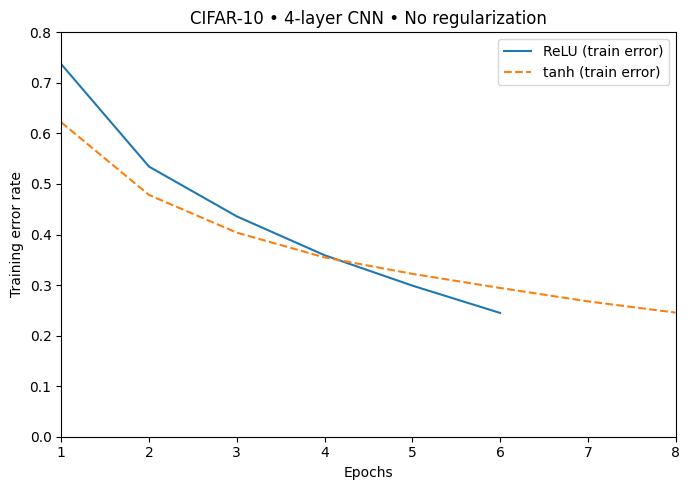

In [16]:

plt.figure(figsize=(7,5))
plt.plot(range(1, len(relu_err)+1), relu_err, label="ReLU (train error)")
plt.plot(range(1, len(tanh_err)+1), tanh_err, label="tanh (train error)", linestyle="--")
plt.xlabel("Epochs"); plt.ylabel("Training error rate")
plt.ylim(0, 0.8); plt.xlim(1, max(len(relu_err), len(tanh_err)))
plt.legend(); plt.title("CIFAR-10 • 4-layer CNN • No regularization")
plt.tight_layout()
plt.show()


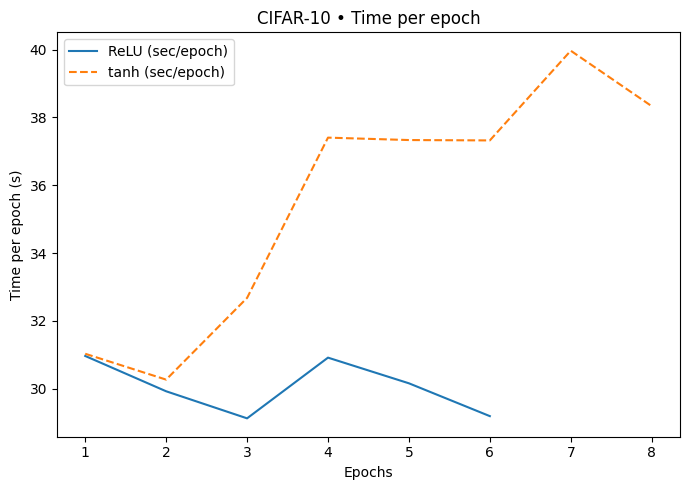

In [17]:

plt.figure(figsize=(7,5))
plt.plot(range(1, len(relu_time)+1), relu_time, label="ReLU (sec/epoch)")
plt.plot(range(1, len(tanh_time)+1), tanh_time, label="tanh (sec/epoch)", linestyle="--")
plt.xlabel("Epochs"); plt.ylabel("Time per epoch (s)")
plt.legend(); plt.title("CIFAR-10 • Time per epoch")
plt.tight_layout()
plt.show()


Saved CSV and figures in current directory.


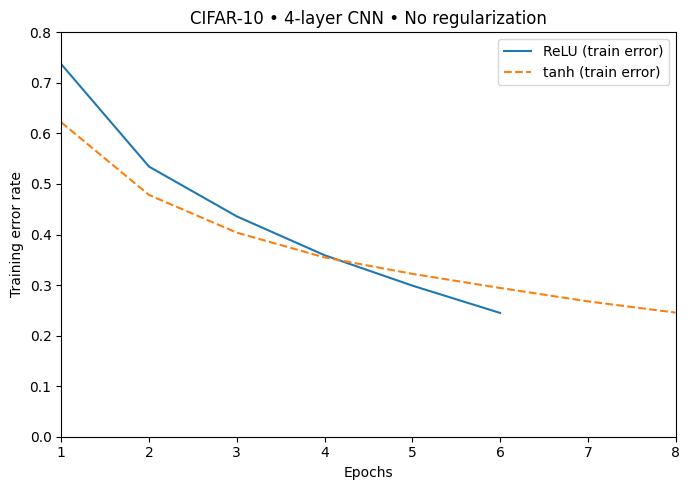

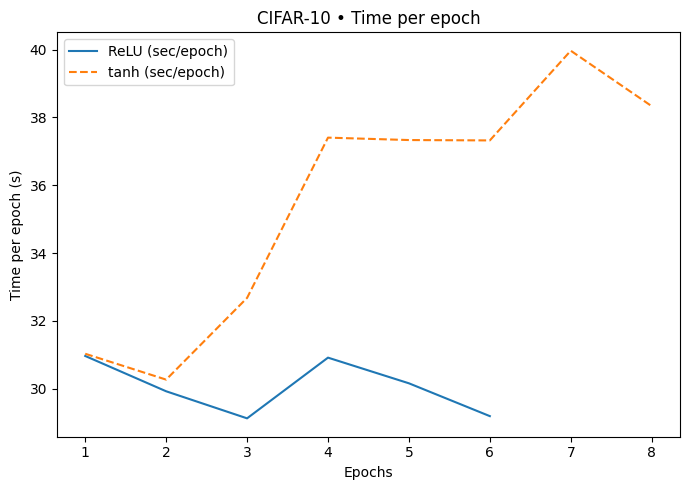

In [18]:

import csv

def save_series(fname, series):
    with open(fname, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["epoch_index_starting_at_1", "value"])
        for i,v in enumerate(series, start=1):
            w.writerow([i, v])

save_series("relu_training_error.csv", relu_err)
save_series("tanh_training_error.csv", tanh_err)
save_series("relu_sec_per_epoch.csv", relu_time)
save_series("tanh_sec_per_epoch.csv", tanh_time)

# Save plots, too
plt.figure(figsize=(7,5))
plt.plot(range(1, len(relu_err)+1), relu_err, label="ReLU (train error)")
plt.plot(range(1, len(tanh_err)+1), tanh_err, label="tanh (train error)", linestyle="--")
plt.xlabel("Epochs"); plt.ylabel("Training error rate")
plt.ylim(0, 0.8); plt.xlim(1, max(len(relu_err), len(tanh_err)))
plt.legend(); plt.title("CIFAR-10 • 4-layer CNN • No regularization")
plt.tight_layout()
plt.savefig("q2_training_error_vs_epochs.png", dpi=140)

plt.figure(figsize=(7,5))
plt.plot(range(1, len(relu_time)+1), relu_time, label="ReLU (sec/epoch)")
plt.plot(range(1, len(tanh_time)+1), tanh_time, label="tanh (sec/epoch)", linestyle="--")
plt.xlabel("Epochs"); plt.ylabel("Time per epoch (s)")
plt.legend(); plt.title("CIFAR-10 • Time per epoch")
plt.tight_layout()
plt.savefig("q2_time_per_epoch.png", dpi=140)

print("Saved CSV and figures in current directory.")
